### Importing Necessary Libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
import seaborn as sns

### Define Paths and Parameters

In [2]:
image_folder = 'images'  
train_df = pd.read_csv('train.csv')  
val_df = pd.read_csv('val.csv')  
test_df = pd.read_csv('test.csv')  
image_size = (224, 224) 

### Define Image Processing Functions

In [3]:
def contrast_stretching(image):
    min_val = np.min(image)
    max_val = np.max(image)
    contrast_stretched_image = (image - min_val) * (255.0 / (max_val - min_val))
    return contrast_stretched_image.astype(np.uint8)

def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, strength=1.5):
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = cv2.addWeighted(image, 1 + strength, blurred, -strength, 0)
    return sharpened

def load_and_preprocess_images(image_filenames, image_folder, image_size):
    images = []
    for filename in image_filenames:
        image_path = os.path.join(image_folder, filename)
        
        img = cv2.imread(image_path)
        if img is not None:
            img = contrast_stretching(img)
            
            img = unsharp_mask(img)
            
            img = cv2.resize(img, image_size)  
            img = img / 255.0  
            images.append(img)
        else:
            print(f"Warning: Failed to load image {filename}")
    return np.array(images)

### Load and Preprocess Images for Training, Validation, and Testing

In [4]:
train_images = load_and_preprocess_images(train_df['filename'], image_folder, image_size)
train_labels = train_df['label'].values

val_images = load_and_preprocess_images(val_df['filename'], image_folder, image_size)
val_labels = val_df['label'].values

test_images = load_and_preprocess_images(test_df['filename'], image_folder, image_size)
test_labels = test_df['label'].values

train_labels = to_categorical(train_labels)
val_labels = to_categorical(val_labels)
test_labels = to_categorical(test_labels)

print(f"Train images shape: {train_images.shape}")
print(f"Validation images shape: {val_images.shape}")
print(f"Test images shape: {test_images.shape}")

Train images shape: (2218, 224, 224, 3)
Validation images shape: (634, 224, 224, 3)
Test images shape: (319, 224, 224, 3)


### Define the CNN Model

In [5]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  
model.add(Dense(train_labels.shape[1], activation='softmax')) 

### Compile the Model

In [6]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

In [7]:
model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=10, batch_size=32)

Epoch 1/10
70/70 [==============================] - 146s 2s/step - loss: 0.8694 - accuracy: 0.7344 - val_loss: 0.3578 - val_accuracy: 0.8707
Epoch 2/10
70/70 [==============================] - 139s 2s/step - loss: 0.3443 - accuracy: 0.8706 - val_loss: 0.3048 - val_accuracy: 0.8943
Epoch 3/10
70/70 [==============================] - 137s 2s/step - loss: 0.2765 - accuracy: 0.8977 - val_loss: 0.3423 - val_accuracy: 0.8707
Epoch 4/10
70/70 [==============================] - 135s 2s/step - loss: 0.2295 - accuracy: 0.9179 - val_loss: 0.2849 - val_accuracy: 0.8991
Epoch 5/10
70/70 [==============================] - 149s 2s/step - loss: 0.1565 - accuracy: 0.9405 - val_loss: 0.2442 - val_accuracy: 0.9196
Epoch 6/10
70/70 [==============================] - 137s 2s/step - loss: 0.1124 - accuracy: 0.9648 - val_loss: 0.2392 - val_accuracy: 0.9259
Epoch 7/10
70/70 [==============================] - 136s 2s/step - loss: 0.0656 - accuracy: 0.9766 - val_loss: 0.2061 - val_accuracy: 0.9416
Epoch 8/10
70

### Evaluate the Model on the Test Set

In [8]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

10/10 [==============================] - 4s 434ms/step - loss: 0.1808 - accuracy: 0.9342
Test Accuracy: 93.42%


### Classification Report

In [9]:
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)  

y_true = np.argmax(test_labels, axis=1)  
disease_classes = [
    "Apple Scab",
    "Cedar Apple Rust",
    "Healthy",
    "Black Rot"
]
report = classification_report(y_true, y_pred_classes, target_names=disease_classes)
print("Classification Report:\n", report)

10/10 [==============================] - 5s 427ms/step
Classification Report:
                   precision    recall  f1-score   support

      Apple Scab       0.91      0.83      0.87        63
Cedar Apple Rust       0.88      1.00      0.93        28
         Healthy       0.97      0.95      0.96       165
       Black Rot       0.90      0.97      0.93        63

        accuracy                           0.93       319
       macro avg       0.91      0.94      0.92       319
    weighted avg       0.94      0.93      0.93       319



### Confusion Matrix

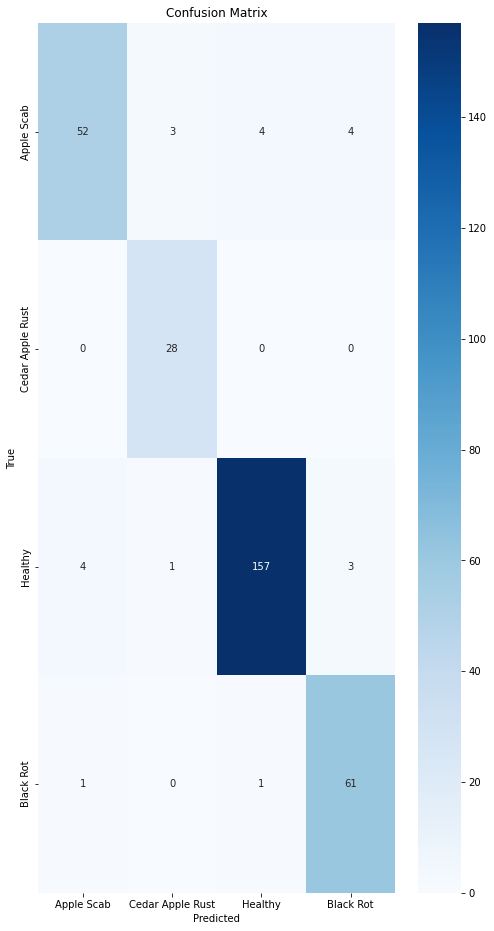

In [10]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 16))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=disease_classes, yticklabels=disease_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Save the Model for Later Use

In [11]:
model.save('DipDiseaseDetection.h5')

### Predict on a New Image

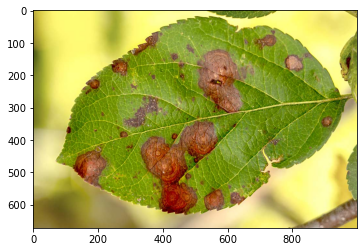

In [12]:
new_image = cv2.imread('frogeye-1.jpg')
new_image_rgb = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
plt.imshow(new_image_rgb) 

### Preprocess the new image

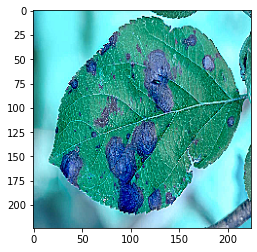

In [13]:
new_image = cv2.resize(new_image, image_size)
new_image = contrast_stretching(new_image)  
new_image = unsharp_mask(new_image)  
plt.imshow(new_image)
cv2.imwrite(new_image)
new_image = new_image / 255.0
new_image = np.expand_dims(new_image, axis=0)

### Make Prediction

In [14]:
prediction = model.predict(new_image)
predicted_class = int(np.argmax(prediction, axis=1)[0])

print(f"Predicted class: {predicted_class}")
print(f"Predicted Disease: {disease_classes[predicted_class-1]}")

1/1 [==============================] - 0s 99ms/step
Predicted class: 2
Predicted Disease: Cedar Apple Rust


### Load the Model for Later Use

In [15]:
model = load_model('DipDiseaseDetection.h5')